# 07 Mean Teacher on CIFAR‑10 (few labels)

Here we add a *teacher* that is an EMA of the student.

The key idea: smoother targets → less volatility early on.



### Why EMA helps early

The student is volatile at the start. EMA smooths targets so the state doesn’t swing wildly.

This is the teacher’s main stabilizing effect.



## Step 1: Imports

We’ll run Mean Teacher with either CIFAR‑10 or a fast MNIST dev run.



In [1]:
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'src'))

from utils.seed import set_seed
from data.mnist import get_mnist_ssl
from data.cifar10 import get_cifar10_ssl_twoview
from models.small_cnn import SmallCNN
from models.resnet18 import build_resnet18
from methods.mean_teacher import run_mean_teacher
from methods.supervised import run_supervised


### Two-View Mean Teacher (CIFAR-10)

For a stronger SSL signal, the teacher and student should see different views of the same unlabeled image.

- Teacher gets a weak augmentation, student gets a strong augmentation.
- The consistency loss encourages stable predictions across views.
- We ramp `lambda_u` over the first few epochs to avoid early collapse.

This setup usually yields a clearer improvement over the supervised-only baseline.


## Step 2: Choose data + model

Set `FAST_DEV_RUN=False` for the full CIFAR‑10 experiment.



## Step 3: Train Mean Teacher

Pay attention to disagreement and how stable the curve looks.



In [ ]:
set_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FAST_DEV_RUN = False

if FAST_DEV_RUN:
    loaders = get_mnist_ssl('data', labeled_per_class=50, batch_size=128, num_workers=2, seed=0)
    student = SmallCNN()
    teacher = SmallCNN()
    epochs = 2
    ema_decay = 0.99
    lambda_u = 1.0
    warmup_epochs = 0
else:
    loaders = get_cifar10_ssl_twoview('data', labeled_per_class=40, batch_size=128, num_workers=2, seed=0)
    student = build_resnet18()
    teacher = build_resnet18()
    epochs = 100
    ema_decay = 0.999
    lambda_u = 10.0
    warmup_epochs = 10

optimizer = torch.optim.SGD(student.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
result = run_mean_teacher(
    student,
    teacher,
    loaders.labeled,
    loaders.unlabeled,
    loaders.test,
    optimizer,
    DEVICE,
    epochs=epochs,
    ema_decay=ema_decay,
    lambda_u=lambda_u,
    warmup_epochs=warmup_epochs,
    use_progress=True,
)

baseline_model = SmallCNN() if FAST_DEV_RUN else build_resnet18()
baseline_optimizer = torch.optim.SGD(
    baseline_model.parameters(),
    lr=0.03,
    momentum=0.9,
    weight_decay=5e-4,
)
baseline = run_supervised(
    baseline_model,
    loaders.labeled,
    loaders.test,
    baseline_optimizer,
    DEVICE,
    epochs=epochs,
    use_progress=True,
)


Text(0, 0.5, 'acc')

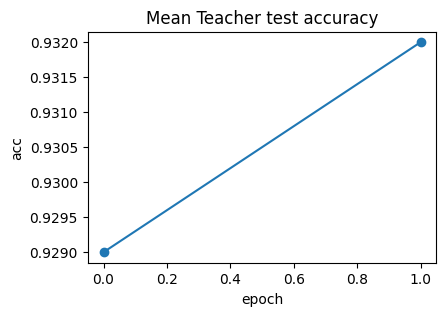

In [ ]:
plt.figure(figsize=(4.5, 3))
plt.plot([r['epoch'] for r in result.history], [r['test_acc'] for r in result.history], marker='o', label='Mean Teacher')
plt.plot([r['epoch'] for r in baseline.history], [r['test_acc'] for r in baseline.history], marker='o', label='Supervised baseline')
plt.title('Mean Teacher vs supervised baseline')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


### Expected Outcome

The Mean Teacher curve should exceed the supervised baseline after the warm‑up period.
If it does not, increase the number of epochs or tune `lambda_u`/`ema_decay`.


## Observations → Why → SSL opportunity

**What you’ll likely see**

- Test accuracy rises steadily, often more smoothly than FixMatch.

- Teacher–student disagreement shrinks over time.



**Why this happens**

- EMA dampens short‑term noise in the student.

- The teacher provides stable, low‑variance targets.



**SSL opportunity**

- Temporal ensembling is a simple but powerful stabilizer.

